# Evaluate the registration performance of SuperRetina on FIRE dataset.

## Environment
+ Ubuntu 18.04.5 LTS
+ Python 3.8.8
+ conda install pytorch==1.8.2 torchvision==0.9.2 -c pytorch
+ See requirements.txt for other python packages

In [1]:
import os
os.chdir("..")

import numpy as np
from tqdm import tqdm

from common.eval_util import compute_auc
from predictor import Predictor
import os
import cv2
import yaml

## Step 1. Read evaluation config.

In [2]:
config_path = './config/test.yaml'
if os.path.exists(config_path):
    with open(config_path) as f:
        config = yaml.safe_load(f)
else:
    raise FileNotFoundError("Config File doesn't Exist")

predict_config = config['PREDICT']
data_path = './data/'  # Change the data_path according to your own setup
testset = 'FIRE'
use_matching_trick = config['PREDICT']['use_matching_trick']
gt_dir = os.path.join(data_path, testset, 'Ground Truth')
im_dir = os.path.join(data_path, testset, 'Images')

match_pairs = [x for x in os.listdir(gt_dir) if x.endswith('.txt')
                   and not x.endswith('P37_1_2.txt')]
# metrics
big_num = 1e6
good_nums_rate = []
image_num = 0

failed = 0
inaccurate = 0
mae = 0
mee = 0

# category: S, P, A, corresponding to Easy, Hard, Mod in paper
auc_record = dict([(category, []) for category in ['S', 'P', 'A']])

In [3]:
print('-'*50)
print('nms size: {} \nnms threshold: {}'.format(predict_config['nms_size'], 
                                                predict_config['nms_thresh']))
print('knn threshold: {}'.format(predict_config['knn_thresh']))
print('-'*50)

print("NOTE:")
print("\t The raw image size of FIRE is (2912, 2912)")
print(f"\t The running size of SuperRetina is {predict_config['model_image_height'], predict_config['model_image_width']}")
print()
print("Homography matrix will be computed at the running size, and then mapping to the raw size")

--------------------------------------------------
nms size: 10 
nms threshold: 0.01
knn threshold: 0.9
--------------------------------------------------
NOTE:
	 The raw image size of FIRE is (2912, 2912)
	 The running size of SuperRetina is (768, 768)

Homography matrix will be computed at the running size, and then mapping to the raw size


## Step 2. Build the predictor for image matching and registration.

In [4]:
Pred = Predictor(config)
query_path = './data/samples/query.jpg'
refer_path = './data/samples/refer.jpg'

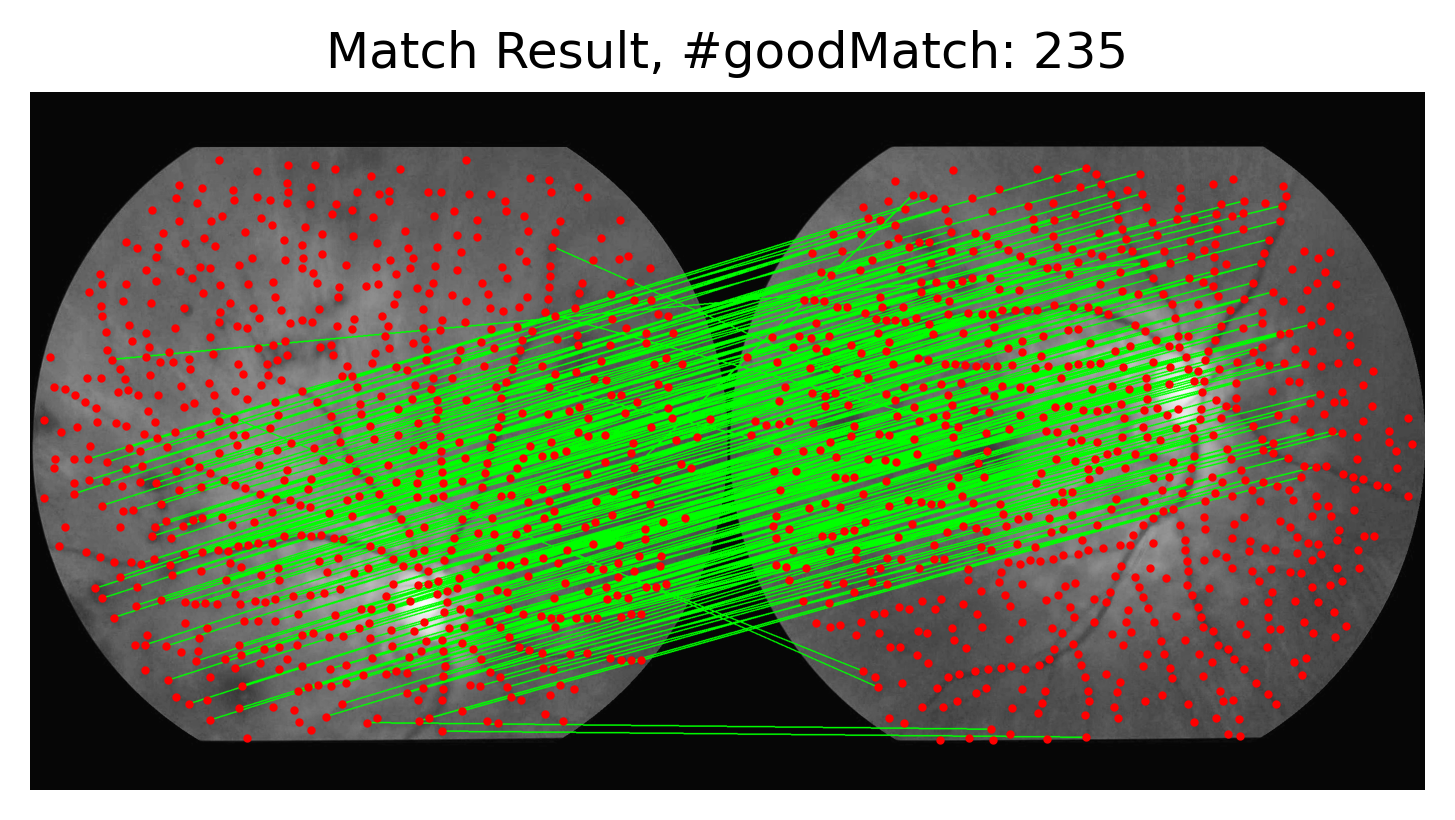

In [5]:
# the usage example of the predictor

# for matching
if query_path is not None:
    goodMatch, cv_kpts_query, cv_kpts_refer, \
            raw_query_image, raw_refer_image = Pred.match(query_path, refer_path, show=True)
else:
    print('query path is None, doesn\'t show matching')

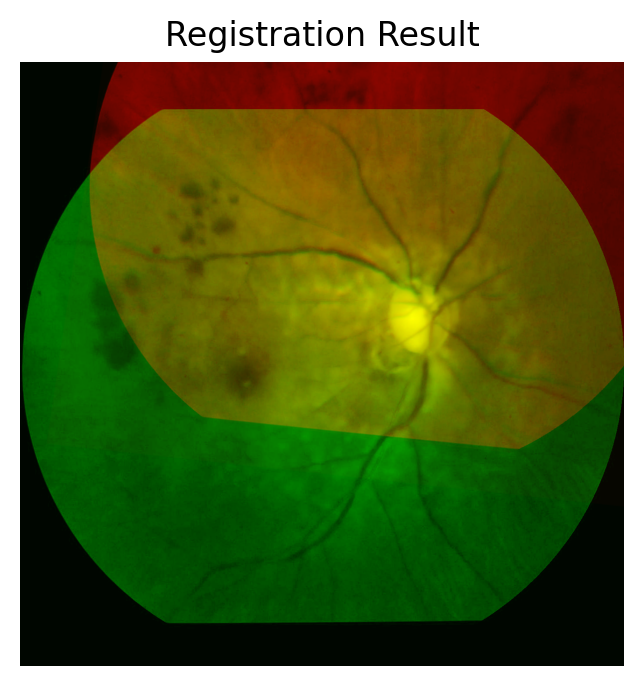

Homography Matrix is :
[[ 9.78631481e-01 -1.46363911e-01  2.60430481e+02]
 [ 1.13502810e-01  9.50049917e-01 -4.75862100e+02]
 [ 7.76188605e-06 -3.01562860e-05  1.00000000e+00]]
The rate of inliers is 94.468%


In [6]:
# for registration
if query_path is not None:
    H_m, inliers_num_rate, raw_query_image, raw_refer_image = Pred.compute_homography(query_path, refer_path)
    merged = Pred.align_image_pair(query_path, refer_path, show=True)
    
    print("Homography Matrix is :")
    print(H_m)
    print("The rate of inliers is {:.3f}%".format(inliers_num_rate*100))
else:
    print('query path is None, doesn\'t show registration')

## Step 3. Evaluation on FIRE.

In [7]:
for pair_file in tqdm(match_pairs):
    gt_file = os.path.join(gt_dir, pair_file)
    file_name = pair_file.replace('.txt', '')

    category = file_name.split('_')[2][0]

    refer = file_name.split('_')[2] + '_' + file_name.split('_')[3]
    query = file_name.split('_')[2] + '_' + file_name.split('_')[4]

    query_im_path = os.path.join(im_dir, query + '.jpg')
    refer_im_path = os.path.join(im_dir, refer + '.jpg')
    H_m1, inliers_num_rate, query_image, _ = Pred.compute_homography(query_im_path, refer_im_path)
    H_m2 = None
    
    # Using matching trick will decrease inference speed but gain higher performance
    if use_matching_trick:
        if H_m1 is not None:
            h, w = Pred.image_height, Pred.image_width
            query_align_first = cv2.warpPerspective(query_image, H_m1, (w, h), borderMode=cv2.BORDER_CONSTANT,
                                              borderValue=(0))
            query_align_first = query_align_first.astype(float)
            query_align_first /= 255.
            H_m2, inliers_num_rate, _, _ = Pred.compute_homography(query_align_first, refer_im_path, query_is_image=True)

    good_nums_rate.append(inliers_num_rate)
    image_num += 1

    if inliers_num_rate < 1e-6:
        failed += 1
        avg_dist = big_num
    else:
        points_gd = np.loadtxt(gt_file)
        raw = np.zeros([len(points_gd), 2])
        dst = np.zeros([len(points_gd), 2])
        raw[:, 0] = points_gd[:, 2]
        raw[:, 1] = points_gd[:, 3]
        dst[:, 0] = points_gd[:, 0]
        dst[:, 1] = points_gd[:, 1]
        dst_pred = cv2.perspectiveTransform(raw.reshape(-1, 1, 2), H_m1)
        if H_m2 is not None:
            dst_pred = cv2.perspectiveTransform(dst_pred.reshape(-1, 1, 2), H_m2)

        dst_pred = dst_pred.squeeze()

        dis = (dst - dst_pred) ** 2
        dis = np.sqrt(dis[:, 0] + dis[:, 1])
        avg_dist = dis.mean()
        
        mae = dis.max()
        mee = np.median(dis)
        if mae > 50 or mee > 20:
            inaccurate += 1
    
    auc_record[category].append(avg_dist)

100%|███████████████████████████████████████████████████████████████████| 133/133 [05:22<00:00,  2.43s/it]


## Step 4. Output the metircs.

In [8]:
print('-'*40)
print(f"Failed:{'%.2f' % (100*failed/image_num)}%, Inaccurate:{'%.2f' % (100*inaccurate/image_num)}%, "
      f"Acceptable:{'%.2f' % (100*(image_num-inaccurate-failed)/image_num)}%")

print('-'*40)

auc = compute_auc(auc_record['S'], auc_record['P'], auc_record['A'])
print('S: %.3f, P: %.3f, A: %.3f, mAUC: %.3f' % (auc['s'], auc['p'], auc['a'], auc['mAUC']))


--------------------
Failed:0.00%, Inaccurate:1.50%, Acceptable:98.50%
--------------------
S: 0.950, P: 0.554, A: 0.783, mAUC: 0.762
